# Compare VAR model accuracy with respect to forecast length

In [1]:
import pandas as pd
import numpy as np

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests
from statsmodels.tsa.statespace.varmax import VARMAX

## Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

import yfinance as yf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

## Read the file

In [2]:
df = pd.read_csv('../Data/dataset_others.csv')
# Extract _change_in_price columns
change_in_price_cols = [col for col in df.columns if '_change_in_price' in col]
df_change = df[change_in_price_cols].copy()

In [3]:
change_in_price_cols

['ALV_change_in_price',
 'F_change_in_price',
 'GM_change_in_price',
 'TM_change_in_price',
 'TRYUSD=X_change_in_price',
 'WFC_change_in_price',
 'X_change_in_price',
 'ALI=F_change_in_price',
 'DNZOY_change_in_price']

In [4]:
change_in_price_cols.pop()

'DNZOY_change_in_price'

In [5]:
change_in_price_cols

['ALV_change_in_price',
 'F_change_in_price',
 'GM_change_in_price',
 'TM_change_in_price',
 'TRYUSD=X_change_in_price',
 'WFC_change_in_price',
 'X_change_in_price',
 'ALI=F_change_in_price']

In [6]:
forecast_length = [5, 10, 15, 20, 25, 30, 35, 40]

In [7]:
cols = ['Ticker']
for i in range(len(forecast_length)):
    cols.append('n = '+ str(forecast_length[i]))
cols
accuracy = pd.DataFrame(columns=cols)
#results_adf['Company'] = ['Apple','Google','Microsoft','NVIDIA','Amazon','Meta','TSMC']

In [8]:
accuracy

,Ticker,n = 5,n = 10,n = 15,n = 20,n = 25,n = 30,n = 35,n = 40


In [9]:
s = 'ALV_change_in_price'
s.split('_')

['ALV', 'change', 'in', 'price']

In [10]:
for i, t in enumerate(change_in_price_cols):
    accuracy.loc[i, 'Ticker'] = t.split('_')[0]

In [11]:
accuracy

,Ticker,n = 5,n = 10,n = 15,n = 20,n = 25,n = 30,n = 35,n = 40
0,ALV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TRYUSD=X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,WFC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ALI=F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## VAR model for each ticker and each forecast length

In [12]:
for i in range(len(forecast_length)):
    for j in range(len(change_in_price_cols)):
        df_temp = df_change[['DNZOY_change_in_price', change_in_price_cols[j]]].copy()
        train = df_temp.iloc[:-forecast_length[i]]
        test = df_temp.iloc[-forecast_length[i]:]
        model = VAR(train)
        var_model = model.fit(10)
        forecast_var = pd.DataFrame(var_model.forecast(train.values, 
                                              steps=forecast_length[i]), 
                           columns=train.columns, 
                           index=test.index)
        forecast_var = pd.concat([forecast_var['DNZOY_change_in_price'], test['DNZOY_change_in_price']], axis = 1)
        forecast_var.columns = ['DNZOY Prediction', 'DNZOY True Value']
        accuracy.iloc[j, i + 1] = (sum(forecast_var['DNZOY Prediction'].copy()*forecast_var['DNZOY True Value'].copy() > 0)/forecast_length[i])

In [13]:
accuracy

,Ticker,n = 5,n = 10,n = 15,n = 20,n = 25,n = 30,n = 35,n = 40
0,ALV,0.2,0.4,0.533333,0.5,0.52,0.333333,0.342857,0.475
1,F,0.6,0.6,0.266667,0.55,0.36,0.333333,0.342857,0.45
2,GM,0.6,0.5,0.266667,0.3,0.44,0.233333,0.4,0.45
3,TM,0.6,0.8,0.6,0.5,0.48,0.466667,0.371429,0.4
4,TRYUSD=X,0.8,0.7,0.466667,0.4,0.36,0.466667,0.371429,0.475
5,WFC,0.4,0.7,0.733333,0.5,0.36,0.366667,0.428571,0.425
6,X,0.6,0.7,0.533333,0.45,0.48,0.433333,0.314286,0.425
7,ALI=F,0.8,0.6,0.466667,0.35,0.4,0.4,0.342857,0.425


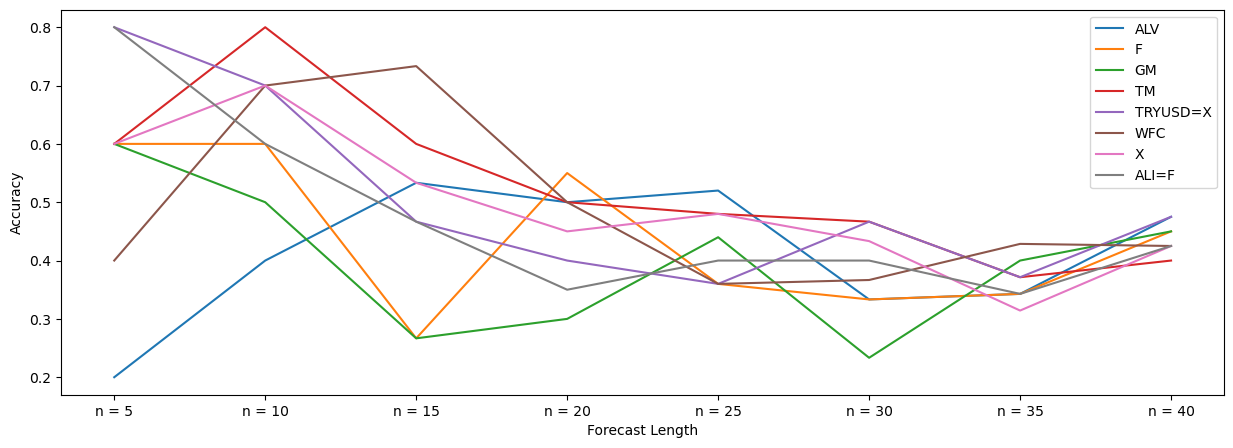

In [23]:
plt.figure(figsize=(15, 5))
for i in range(8):
    plt.plot(accuracy.iloc[i, 1:], label=accuracy.loc[i,'Ticker'])
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Forecast Length')
plt.show()